In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import tikzplotlib
import timeit

In [16]:
# This section is just me figuring out how tensors work
#lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
#upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
#x = tf.random.uniform(shape=[1,100]) # Interior points
#training_pts = tf.concat([lower_bound, x, upper_bound], 1) # Actual training data
#x_0 = tf.slice(training_pts, [0,0], [1,1])
#x_1 = tf.slice(training_pts, [0,101], [1,1])
#print(x_0.numpy(), x_1.numpy())

In [37]:
# Construct Simple Feedforward Network
model = Sequential()
model.add(Dense(100, input_shape=[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
# Define Loss Function
def loss_fn(model,x):
    #print(x)
    with tf.GradientTape() as t:
        t.watch(x)
        f = model(x, training=True)
        #print('f = ', f)
    df_dx = t.gradient(f,x)
    u_0 = tf.zeros(shape=[1,1]) # Lower boundary condition
    u_1 = tf.ones(shape=[1,1]) # Upper boundary condition
    bound_weight = 1000 # lambda = sqrt(bound_weight)
    mse = tf.keras.losses.MeanSquaredError()
    lower_bound_error = tf.math.subtract(tf.slice(f,[0,0],[1,1]),u_0)
    #print(lower_bound_error)
    upper_bound_error = tf.math.subtract(tf.slice(f,[99,0], [1,1]),u_1)
    loss_1 = tf.math.add(tf.nn.l2_loss(df_dx), 
                       tf.nn.l2_loss(bound_weight*lower_bound_error))
    loss = tf.math.add(loss_1, tf.nn.l2_loss(bound_weight*upper_bound_error))
    return loss

In [27]:
def train_for():
    # Train network
    optimizer = tf.keras.optimizers.Adam() # Fancy gradient decent
    epochs = 20
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100
    minibatch_size = 100 # Number of points to be selected each iteration

    for epoch in range(epochs): # Uncomment to run for specific number of epochs
        epoch_loss_avg = tf.keras.metrics.Mean()
        for iteration in range(iterations_per_epoch):
            lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
            upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
            interior_pts = tf.random.uniform(shape=[1,minibatch_size-2]) # Interior points
            x = tf.transpose(tf.concat([lower_bound, interior_pts, upper_bound], 1)) # Actual training data
            with tf.GradientTape() as t:
                t.watch(x)
                #print(x)
                #f = model(x, training=True) # Estimate for u
                loss = loss_fn(model,x) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads,model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        #print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

In [36]:
def train_while():
    # Train network
    optimizer = tf.keras.optimizers.Adam() # Fancy gradient decent
    epochs = 20
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100
    minibatch_size = 100 # Number of points to be selected each iteration
    average_error = 1
    epoch = -1
    while average_error > 0.005: 
        epoch_loss_avg = tf.keras.metrics.Mean()
        for iteration in range(iterations_per_epoch):
            lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
            upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
            interior_pts = tf.random.uniform(shape=[1,minibatch_size-2]) # Interior points
            x = tf.transpose(tf.concat([lower_bound, interior_pts, upper_bound], 1)) # Actual training data
            with tf.GradientTape() as t:
                t.watch(x)
                #print(x)
                #f = model(x, training=True) # Estimate for u
                loss = loss_fn(model,x) # Loss
            grads = t.gradient(loss, model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads,model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        # Check average error    
        lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
        upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
        x = tf.sort(tf.random.uniform(shape=[1,98])) # Interior points
        test_points_tensor = tf.transpose(tf.concat([lower_bound, x, upper_bound], 1)) # Actual data
        test_points = test_points_tensor.numpy()
        g = model(test_points_tensor, training=False).numpy()
        average_error = np.sum(abs(g-test_points))/len(g)
        print(average_error)
        
        train_loss_results.append(epoch_loss_avg.result())
        epoch+=1 
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

0.01918726921081543
Epoch 000: Loss: 34389.535
0.021067743301391603
Epoch 001: Loss: 51.825
0.019925408363342285
Epoch 002: Loss: 51.801
0.017142375707626344
Epoch 003: Loss: 51.555
0.015679073333740235
Epoch 004: Loss: 51.305
0.014307026863098144
Epoch 005: Loss: 51.024
0.014370460510253907
Epoch 006: Loss: 50.765
0.010900721549987794
Epoch 007: Loss: 50.636
0.008479062914848328
Epoch 008: Loss: 50.162
0.006686753630638123
Epoch 009: Loss: 50.810
0.006636239886283875
Epoch 010: Loss: 49.942
0.006756807565689087
Epoch 011: Loss: 49.846
0.0052514588832855225
Epoch 012: Loss: 51.260
0.007859122753143311
Epoch 013: Loss: 50.132
0.00557978093624115
Epoch 014: Loss: 49.772
0.0059672611951828
Epoch 015: Loss: 53.542
0.007546294927597046
Epoch 016: Loss: 52.624
0.0020333418250083925
Epoch 017: Loss: 51.242
0.002020779401063919


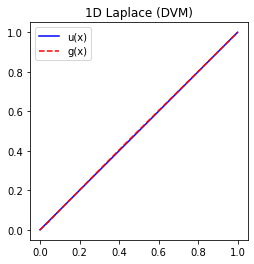

In [35]:
# Run the model with real data
#train_for()
train_while()
lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
x = tf.sort(tf.random.uniform(shape=[1,98])) # Interior points
test_points_tensor = tf.transpose(tf.concat([lower_bound, x, upper_bound], 1)) # Actual data
test_points = test_points_tensor.numpy()
g = model(test_points_tensor, training=False).numpy()
x_actual = tf.sort(tf.random.uniform(shape=[1,1000]).numpy()) # Known solution
#print(test_points[0])
#print(x_actual[0])
#print(f[0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('1D Laplace (DVM)')
ax.plot(x_actual[0],x_actual[0], label='u(x)', color='blue')
ax.plot(test_points,g,'r--', label='g(x)')
ax.legend()
ax.set_aspect('equal','box')

tikzplotlib.save("1d_laplace_dvm.tex")

average_error = np.sum(abs(g-test_points))/len(g)
print(average_error)

In [38]:
print(timeit.timeit(train_while, number=30))

0.022790374755859374
Epoch 000: Loss: 31259.350
0.02458139181137085
Epoch 001: Loss: 54.034
0.017975629568099977
Epoch 002: Loss: 53.777
0.021562142372131346
Epoch 003: Loss: 53.135
0.01789018988609314
Epoch 004: Loss: 52.227
0.015678791999816893
Epoch 005: Loss: 51.807
0.010613255500793457
Epoch 006: Loss: 51.342
0.008882226943969727
Epoch 007: Loss: 50.753
0.006784302592277527
Epoch 008: Loss: 50.371
0.004778414368629456
Epoch 009: Loss: 50.572
0.020943682193756103
Epoch 000: Loss: 1341.982
0.022609233856201172
Epoch 001: Loss: 50.796
0.024339950084686278
Epoch 002: Loss: 50.637
0.026432318687438963
Epoch 003: Loss: 50.545
0.028537845611572264
Epoch 004: Loss: 50.462
0.025351135730743407
Epoch 005: Loss: 50.289
0.022583019733428956
Epoch 006: Loss: 50.197
0.022530758380889894
Epoch 007: Loss: 50.156
0.017663142681121825
Epoch 008: Loss: 49.992
0.014592018127441406
Epoch 009: Loss: 49.889
0.01270254135131836
Epoch 010: Loss: 50.614
0.01215829849243164
Epoch 011: Loss: 49.964
0.0075190

0.030855963230133055
Epoch 002: Loss: 50.388
0.0292840576171875
Epoch 003: Loss: 50.252
0.025808916091918946
Epoch 004: Loss: 50.274
0.016314547061920166
Epoch 005: Loss: 50.095
0.004882034659385681
Epoch 006: Loss: 49.983
0.025812792778015136
Epoch 000: Loss: 491.749
0.024115691184997557
Epoch 001: Loss: 50.857
0.020028209686279295
Epoch 002: Loss: 50.089
0.01493816614151001
Epoch 003: Loss: 49.936
0.007416985034942627
Epoch 004: Loss: 49.884
0.0016963553428649902
Epoch 005: Loss: 49.949
0.02575261116027832
Epoch 000: Loss: 617.766
0.02708092451095581
Epoch 001: Loss: 51.338
0.024208083152770996
Epoch 002: Loss: 50.504
0.020903346538543702
Epoch 003: Loss: 49.972
0.01216444730758667
Epoch 004: Loss: 49.934
0.001988593637943268
Epoch 005: Loss: 50.025
0.020441827774047853
Epoch 000: Loss: 624.345
0.019236342906951906
Epoch 001: Loss: 50.889
0.013284401893615723
Epoch 002: Loss: 50.097
0.004673861265182495
Epoch 003: Loss: 49.699
0.03610732793807983
Epoch 000: Loss: 667.445
0.0267319583